In [6]:
import random
import pickle
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import clip
import torch.nn.functional as F
import csv

In [33]:
class CustomCIFAR100Dataset(Dataset):
    cifar100_dataset = None

    @classmethod
    def load_dataset(cls, root="./data/cifar100", train=True, download=True, transform=None):
        cls.cifar100_dataset = datasets.CIFAR100(root, train=train, download=download, transform=transform)

    def __init__(self):
        if CustomCIFAR100Dataset.cifar100_dataset is None:
            raise RuntimeError("Dataset not loaded. Call load_dataset() before creating instances of this class.")

    def __getitem__(self, index):
        data_point, label = CustomCIFAR100Dataset.cifar100_dataset[index]
        return index, (data_point, label)

    def __len__(self):
        return len(CustomCIFAR100Dataset.cifar100_dataset)

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

crop = transforms.RandomCrop(32, padding=4)
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

preprocess_rand = transforms.Compose([crop, transforms.RandomHorizontalFlip(), preprocess])
CustomCIFAR100Dataset.load_dataset(transform=preprocess_rand)
custom_cifar100_dataset = CustomCIFAR100Dataset()

Files already downloaded and verified


In [36]:
batch_size = 256
print('Data Loader')
data_loader = torch.utils.data.DataLoader(dataset=custom_cifar100_dataset, batch_size=batch_size, shuffle=False)
device = "cuda" if torch.cuda.is_available() else "cpu"

record = [[] for _ in range(100)]

for batch_idx, (index, (data, labels)) in enumerate(data_loader):
    data = data.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        extracted_feature = model.encode_image(data)
    for i in range(extracted_feature.shape[0]):
        record[labels[i]].append({'feature': extracted_feature[i].detach().cpu(), 'index': index[i]})

Data Loader


In [37]:
total_len = sum([len(a) for a in record])
origin_trans = torch.zeros(total_len, record[0][0]['feature'].shape[0])
origin_label = torch.zeros(total_len).long()
index_rec = np.zeros(total_len, dtype=int)
cnt, lb = 0, 0
for item in record:
    for i in item:
        origin_trans[cnt] = i['feature']
        origin_label[cnt] = lb
        index_rec[cnt] = i['index']
        cnt += 1
    lb += 1
labels = np.array(origin_label)

In [38]:
# Print shape of array
tsne = TSNE(n_components=2, p).fit_transform(origin_trans)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


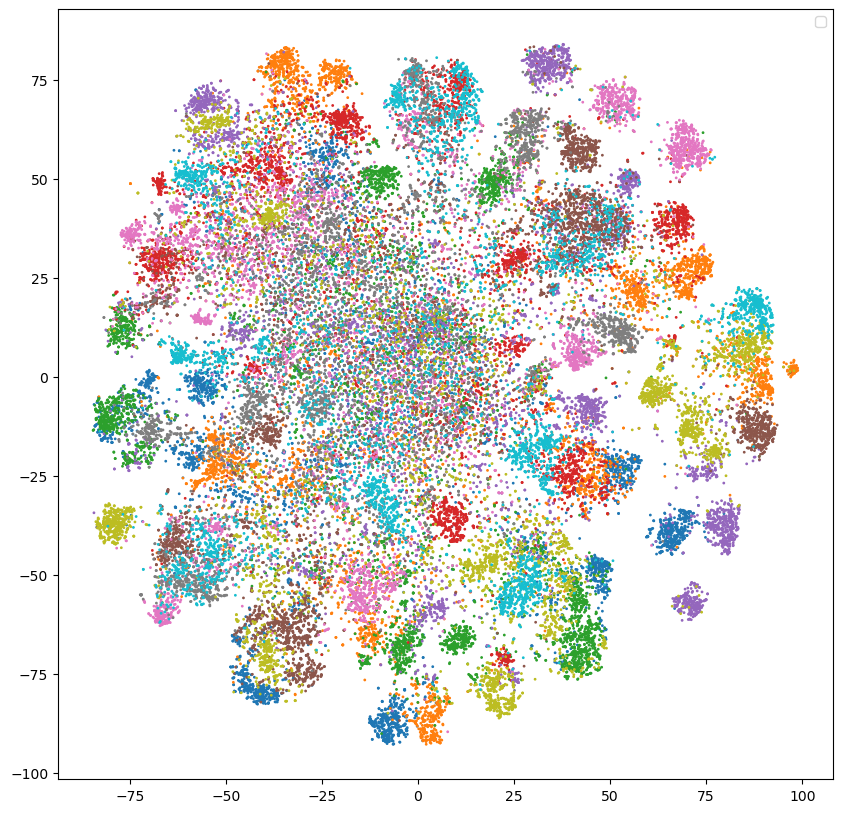

In [40]:
#with open("labels.pkl", "wb") as f:
#    pickle.dump(labels, f)

#tsne_path_name = "tsne_extracted.pkl"
#with open(tsne_path_name, "rb") as f:
#    tsne = pickle.load(f)

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

fig, ax = plt.subplots(figsize=(10, 10))

# for every class, we'll add a scatter plot separately

class_name = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl',
              'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'unknown']



plt.scatter(tx, ty, c=labels, s=1, cmap='tab10' )

# build a legend using the labels we set previously
ax.legend(loc='best')

# finally, show the plot
plt.show()

In [21]:
def load_files(feature_dir, label_dir):
    
    feature = torch.load(feature_dir)
    
    labels = torch.load(label_dir)
    
    return feature, labels

In [108]:
feature_dir = "../features/cifar10_features.pt"

label_dir = "../features/cifar10_labels.pt"

feature, labels = load_files(feature_dir, label_dir)

feature = feature.cpu().numpy()
labels = labels.cpu().numpy()

tsne = TSNE(n_components=2, perplexity=5).fit_transform(feature)

In [167]:
def load_index(pkl):
    
    with open(pkl, "rb") as input_file:
        e = pickle.load(input_file)
    return e

baseline_ = "./log_AL/temperature_resnet18_cifar10_known2_init1_batch400_seed1_AV_temperature_unknown_T0.5_known_T0.5_modelB_T1.0_per_round_query_index.pkl"

active_ = "./log_AL/temperature_resnet18_cifar10_known2_init1_batch400_seed1_active_query_unknown_T0.5_known_T0.5_modelB_T1.0_per_round_query_index.pkl"

baseline = load_index(baseline_)

active = load_index(active_)
b = baseline[-2]

a = active[-2]


active_index = tsne[a]

baseline_index = tsne[b]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


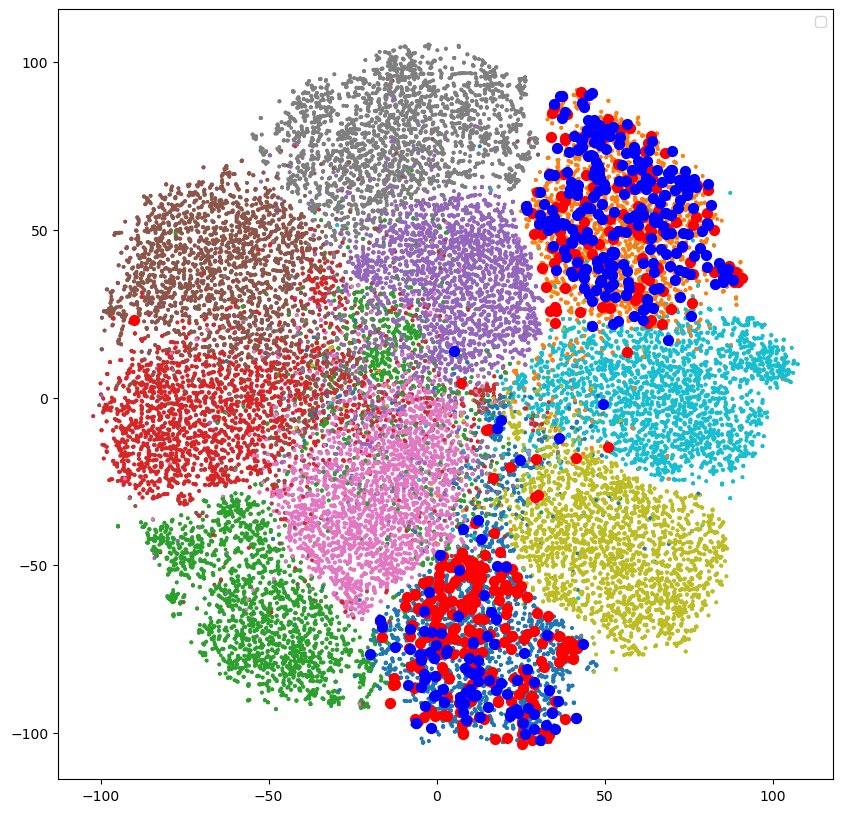

In [168]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

fig, ax = plt.subplots(figsize=(10, 10))

# for every class, we'll add a scatter plot separately

class_name = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl',
              'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'unknown']


ax.scatter(tx, ty, c=labels, s= 3, cmap='tab10' )

ax.scatter(active_index[:, 0], active_index[:, 1],  s= 50, c='r' )


ax.scatter(baseline_index[:, 0], baseline_index[:, 1],  s= 50, c='b' )



# build a legend using the labels we set previously
ax.legend(loc='best')

